# 14. 아이유팬이 좋아할 만한 다른 아티스트 찾기


### 실습 목표
- 추천 시스템의 개념과 목적을 이해한다.

- Implicit 라이브러리를 활용하여 Matrix Factorization(이하 MF) 기반의 추천 모델을 만들어 본다.

- 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해 본다.

- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다

- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.

- 새로운 데이터셋으로 직접 추천 모델을 만들어 본다

### 목차
- 추천 시스템이란 게 뭔가요?

- 데이터 탐색하기와 전처리

- 사용자의 명시적/암묵적 평가

- Matrix Factorization(MF)

- CSR(Compressed Sparse Row) Matrix

- MF 모델 학습하기

- 비슷한 아티스트 찾기 + 유저에게 추천하기

- 프로젝트 - MovieLens 영화 추천 실습

### 데이터 준비

데이터를 로드한다. 데이터에 컬럼명이 없어서 지정해준다.

In [3]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head()

artist_MBID 컬럼은 사용하지 않는다. 제거한다.

In [9]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


In [10]:
# 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data['artist'] = data['artist'].str.lower() 
data.head()

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


첫번째 유저가 어떤 아티스트의 노래를 듣는지 확인

In [4]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


생소한 아티스트들이 많다. 추천 시스템을 잘 사용하려면 도메인 지식이 중요하다. 검증을 해야하기 때문이다.

### 데이터 탐색 

추천 모델을 만들기 전에 데이터의 기본적인 정보를 확인한다. 

- 유저 수, 아티스트 수, 인기 많은 아티스트
- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
- 유저 play 횟수 중앙값 통계

In [11]:
# 총 유저 수
data['user_id'].nunique()

358868

In [12]:
# 총 아티스트 수
data['artist'].nunique()

291346

In [13]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

In [14]:
# 유저별 몇 명의 아티스트를 듣고 있는지 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [15]:
# 유저별 play횟수 중앙값 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

### 모델 검증을 위한 사용자 초기 정보 세팅

자신이 좋아하는 아티스트를 등록한다.

In [16]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


### 모델에 활용하기 위한 전처리 (실습)

user와 artist 각각에 인덱싱을 해준다. 

In [17]:
# 고유한 유저, 아티스트를 찾아낸다.
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 인덱싱
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [18]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358868
376


In [19]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data.head()

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706


## 사용자의 명시적/암묵적 평가

1회만 플레이한 데이터의 비율을 확인

In [24]:
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')

147740,17535660
Ratio of only_one over all data is 0.84%


우리 모델은 암묵적 데이터의 해석을 위해 

1) 한 번이라도 들었으면 선호한다고 판단.

2) 많이 재생한 아티스트에 대해 가중치를 줘서 확실히 좋아한다고 판단.

## Matrix Factorization(MF)

이제 모델을 만들 차례다.

m명의 사용자들이 n명의 아티스트에 대해 평가한 데이터를 포함한 (m,n)사이즈의 평가 행렬을 만든다. 행렬 중 일부는 데이터가 비어있다. 추천 시스템중 하나인 `협업 필터링`은 이런 평가 행렬을 전제로 한다. 만약 우리가 완벽하게 데이터가 채워진 평가 행렬을 얻을 수 있으면 그야말로 완벽한 추천이 가능하다. 

우리는 추천 시스템 모델 중 하나인 **MF**모델을 사용한다. 
(m,n)사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R은 그저 P와 Q의 행렬곱으로 표현할 수 있다는 간단한 아이디어다. 대체로 k는 m이나 n보다 훨씬 작은 값이기 때문에 계산량 측면으로도 훨씬 유리해진다. MF모델은 성능이 준수하고 Scalability가 좋아서 많이 사용되는 모델이다.

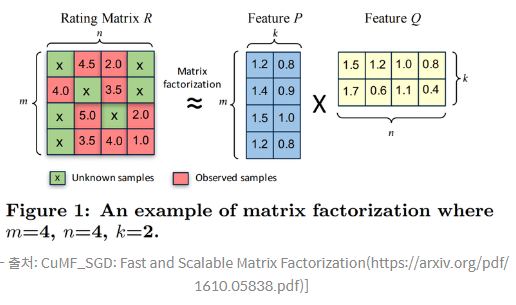

(m,k) 사이즈의 Feature Matrix P는 k차원의 벡터를 사용자 수만큼 모아놓은 행렬이다. 아래 그림에서 첫 번째 벡터 $P_0=(1,0.1)$은 바로 빨간 모자를 쓴 첫 번째 **사용자의 특성(Feature)벡터**가 된다.
같은 방식으로 Q행렬의 첫 번째 벡터 $Q_0=(0.9,-0.2)$는 해리포터 **영화의 특성 벡터**가 된다. MF모델은 두 벡터를 내적해서 얻어지는 0.88이 바로 $R_{0,0}$으로 정의되는 사용자의 영화 선호도로 보는 모델이다.

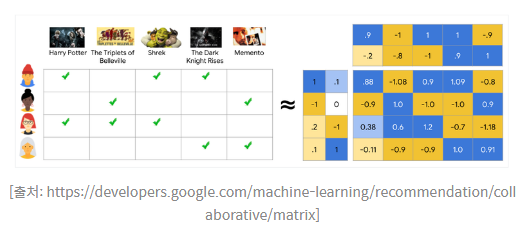

모델의 목표는 모든 유저와 아이템에 대해 k-dimension의 벡터를 잘 만드는 것이다. 
벡터를 잘 만드는 기준은 **유저 i의 벡터($U_i$)와 아이템 j의 벡터($I_j$)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치 ($M_{ij}$)와 비슷한지**이다. $$U_i\cdot I_j = M_{ij}$$

이전 스탭에서 'black eyed peas'를 플레이한 데이터를 추가했기 때문에 'zimin'벡터와 'black eyed peas'의 벡터를 곱했을 때 1에 가까워야 모델이 잘 학습한 것이다. 

모델의 목표는 해당 유저가 해당 아티스트를 선호하는지 맞추는 것이기 때문에 5번을 들었어도 5에 가까워지는 것이 아니라 1에 가까워져야 한다. 

만약 목표가 유저의 재생횟수를 맞추는 것이면 그에 맞는 다른 모델을 사용해야 한다.

## CSR(Compressed Sparse Row) Matrix

유저 X 아이템 평가 행렬을 생각해본다. 유저는 36만 명이고 아티스트는 29만 명이다. 이를 행렬로 표현하고 행렬의 각 원소에 정수 한 개 (1byte)가 들어간다면 36만 * 29만 * 1byte = 97GB가 필요하다.

데이터가 이렇게 커지는 이유는 유저가 들어보지 못한 아티스트에 대한 정보도 함께 포함하고 있어서 그렇다. 
이럴경우 CSR Matrix를 사용하면 좋다. 

CSR Matrix는 Sparse(데이터가 듬성듬성있는)한 Matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 Matrix와 동일한 행렬을 표현할 수 있다. 

CSR Matrix는 data,indices,indptr로 행렬을 압축해서 표현한다. 

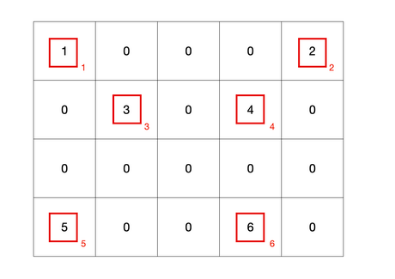

- data : 0이 아닌 원소를 차례로 기입한 값.

`data = [1,2,3,4,5,6]`

- indices : data의 각 요소가 어느 열에 있는지 표현

`indices = [0,4,1,3,0,3]`

- indptr : 각 행에서 0이 아닌 첫 번째 원소가 data리스트에서 몇 번째에 해당하는지와 마지막에 data벡터의 길이를 추가한 값이다. 이를통해 data의 요소들이 어느 행에 있는지 알 수 있다. 다만 예시의 세 번째 행처럼 0이 아닌 원소가 없는 경우 그 다음 행의 값과 같은 값을 넣는다.

`indptr = [0,2,4,4,6]`

- 이를 통해 data[0:2]는 첫 번째 행, data[2:4]는 두 번째 행, data[4:4]는 세 번째 행, data[4:6]는 네 번째 행인 것을 나타낼 수 있다. 


### 우리 data를 가지고 CSR Matrix에 맞게 바꿔본다.

In [25]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Row format>

## MF 모델 학습하기

Matrix Factorization 모델을 implicit패키지를 사용해서 학습한다.

- implicit 패키지는 암묵적 dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지다.

- 이 패키지에 구현된 `als` 모델을 사용한다. `Matrix Factorization`에서 쪼개진 두 Feature Matrix를 한 번에 훈련하는 것은 잘 수렴하지 않는다. 그래서 한 쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적이다.

In [26]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__파라미터를 살펴본다.

1) factors: 유저와 아이템의 벡터를 몇 차원으로 할 것인지

2) regularization: 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지

3) use_gpu: GPU를 사용하는 지

4) iterations: epochs와 같은 의미.

1,4를 늘릴 수록 학습은 잘 되지만 과적합 우려가 있다. 

In [27]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [28]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.int64'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [29]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

1) Zimin 벡터와 black eyed peas의 벡터를 어떻게 만들고 있는지

2) 두 벡터를 곱하면 어떤 값이 나오는지

두 가지를 확인해본다.

In [30]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [31]:
zimin_vector

array([ 0.41348216,  0.78341556, -0.24294652, -0.1912244 , -0.48446283,
       -1.3138978 ,  0.21714865,  0.8313483 , -0.6571444 , -0.34520116,
        0.03773383, -1.2697508 , -0.920961  , -1.0470322 , -0.4477589 ,
       -0.5119132 , -0.09184418,  0.63000786, -0.25090334,  1.1988573 ,
       -0.7208264 ,  0.17246607,  0.66913545,  0.9967889 ,  0.29428768,
        0.6501782 , -1.1175262 , -0.3563806 ,  0.3144182 , -0.43937576,
       -0.5717228 ,  0.19209017,  1.018463  ,  0.9639556 ,  0.64527655,
        0.3549932 , -0.1185156 ,  0.03814609, -0.14763306,  0.22545126,
       -0.5476294 ,  0.9240057 ,  0.01522023, -0.05180057, -0.98855615,
       -1.044008  , -0.1154485 ,  0.5659708 , -0.7608224 , -0.6244814 ,
       -0.6855251 ,  0.0219413 , -0.62383145, -0.05847148, -0.00410022,
       -1.0795745 , -0.01967543,  0.04004795,  0.21706729,  0.38466594,
       -0.06566136,  0.2165214 ,  0.25490507,  0.33903563, -1.1688515 ,
        0.14562848,  0.6059217 , -0.7115942 ,  0.41569   , -0.40

In [32]:
black_eyed_peas_vector

array([ 3.15232016e-03,  6.49665622e-03, -6.07711682e-03,  1.52285602e-02,
       -1.27043098e-03, -1.51536427e-02,  9.93899070e-03,  3.90686840e-03,
        4.18346375e-03,  1.44365048e-02, -2.38930434e-03, -1.21943112e-02,
       -4.23281133e-04,  9.43488162e-03,  6.49187062e-03, -8.56875442e-03,
        6.83572330e-03,  8.34838394e-03,  1.72242187e-02,  2.50247307e-02,
        1.19818468e-02,  5.35464473e-03,  2.02590171e-02,  2.22671274e-02,
        9.34739877e-03, -9.07235080e-04, -4.48724441e-03, -3.16994777e-03,
        1.26637779e-02,  2.21536684e-04,  4.75803186e-04,  7.01601291e-03,
        1.40243582e-02,  2.18086857e-02,  1.34216435e-02,  9.28326882e-03,
        1.83116924e-02,  1.53775802e-02,  8.62066634e-03,  1.09357117e-02,
       -1.86241069e-03,  2.12288834e-02,  4.15685214e-03,  8.03515140e-04,
       -2.08968781e-02, -2.30584221e-04,  1.06508415e-02,  3.12368822e-04,
       -2.23373249e-03,  4.49229823e-03,  3.83545202e-03, -8.63164663e-04,
       -1.21386852e-02,  

In [33]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.50265473

1이 나와야 하지만 0.5가 나왔다. factor를 늘리거나 iteration를 늘려서 학습을 더 시켜야 한다. 일단은 이렇게 학습된 모델을 사용한다.

In [34]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.31432143

모델을 잘 만들려면 데이터에 대한 이해도가 높아야 한다. 추천 시스템에서 사용하는 데이터는 사람에 대한 데이터기 때문이다. 

## 비슷한 아티스트 찾기 + 유저에게 추천하기

### 비슷한 아티스트 찾기

AlternatingLeastSquares 클래스에 있는 similar_items메서드로 비슷한 아티스트를 찾는다. 

In [35]:
favorite_artist = 'coldplay'

artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 0.9999999),
 (277, 0.9879517),
 (28, 0.98273236),
 (5, 0.98097545),
 (217, 0.9744012),
 (473, 0.97050965),
 (490, 0.96648014),
 (247, 0.9641517),
 (910, 0.95382994),
 (1018, 0.9535121),
 (418, 0.952978),
 (55, 0.9500043),
 (694, 0.9480594),
 (782, 0.94649255),
 (776, 0.93814546)]

In [36]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'red hot chili peppers',
 'radiohead',
 'placebo',
 'oasis',
 'the beatles',
 'nirvana',
 'the smashing pumpkins',
 'u2',
 'arctic monkeys',
 'foo fighters',
 'the white stripes',
 'the cure']

In [37]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("슝=3")

슝=3


In [38]:
get_similar_artist('2pac')

['2pac',
 'the game',
 'nas',
 'snoop dogg',
 'notorious b.i.g.',
 'dr. dre',
 '50 cent',
 'jay-z',
 'dmx',
 'ludacris']

마니아는 특정 장르에 선호도가 집중되어 같은 장르의 아티스트들의 벡터가 가까워져서 장르별 특성이 두드러진다.

In [39]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'katy perry',
 'rihanna',
 'beyoncé',
 'the pussycat dolls',
 'kelly clarkson',
 'christina aguilera',
 'leona lewis',
 'kylie minogue']

### 유저에게 아티스트 추천하기

recommend 메서드로 좋아할 만한 아티스트를 추천받는다. filter_already_liked_items는 유저가 이미 평가한 아이템은 제외한다.

In [40]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(350, 0.44248927),
 (369, 0.44070834),
 (550, 0.42143047),
 (627, 0.41593874),
 (409, 0.4145381),
 (274, 0.4095019),
 (354, 0.402414),
 (2249, 0.3952031),
 (564, 0.3937336),
 (391, 0.3898338),
 (1800, 0.38891435),
 (355, 0.38711056),
 (621, 0.3796457),
 (724, 0.37467697),
 (24, 0.36337394),
 (35, 0.35886544),
 (5, 0.3579524),
 (5555, 0.35614088),
 (382, 0.3539834),
 (28, 0.35327724)]

In [41]:
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'justin timberlake',
 'britney spears',
 'maroon 5',
 'amy winehouse',
 'michael jackson',
 'nelly furtado',
 'katy perry',
 'kanye west',
 'christina aguilera',
 'lady gaga',
 'madonna',
 'alicia keys',
 'lily allen',
 'jack johnson',
 'john mayer',
 'red hot chili peppers',
 'timbaland',
 'mika',
 'the killers']

모델은 rihanna를 추천하고 있다. AlternatingLeastSquares의 explain 메서드를 사용하면 기록을 남긴 데이터 중 **이 추천에 기여한 정도**를 확인할 수 있다.

In [42]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

이 메서드는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도를 반환한다.

In [43]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.20776943464843706),
 ('black eyed peas', 0.13143205371481068),
 ('jason mraz', 0.06319534278942261),
 ('coldplay', 0.04155009660497293),
 ('maroon5', 0.0002837318999075125)]

비욘세와 블랙아이드피스가 가장 크게 기여했다. 

maroon5는 이미 평가한 아이템인데 버그로 인해 출력되고 있다. 이럴경우 Pull Request를 통해서 수정을 제안할 수 있다. 

# 실습 : Movielens 영화 추천 실습

## 규칙

- MovieLens 1M Dataset 사용
- 별점 데이터는 대표적인 explicit 데이터다. 하지만 implicit데이터로 간주하고 테스트할 수도 있다.
- 별점을 시청횟수로 해석한다.
- 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

## 1) 데이터 준비와 전처리

Movielens 데이터는 rating.dat안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 들어있다.

In [729]:
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [730]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [731]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [720]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


id를 가지고 타이틀을, 타이틀을 가지고 id를 찾기 쉽게 딕셔너리 생성

In [610]:
id_to_title = {m_id:title for m_id, title in zip(movies['movie_id'], movies['title'])}
title_to_id = {title:m_id for m_id, title in zip(movies['movie_id'], movies['title'])}

## 2) 분석하기

- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [468]:
print(f"ratings에 있는 유니크한 영화 개수 : {ratings['movie_id'].nunique()}")
print(f"ratings에 있는 유니크한 영화 개수 : {ratings['user_id'].nunique()}")

ratings에 있는 유니크한 영화 개수 : 3633
ratings에 있는 유니크한 영화 개수 : 6040


In [571]:
# 가장 인기있는 영화 30가지
most_view_movies = ratings.groupby('movie_id', as_index=False)['user_id'].count().sort_values('user_id', ascending=False)[:30]

for i in most_view_movies.loc[:,'movie_id']:
    print(id_to_title[i])

American Beauty (1999)
Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Saving Private Ryan (1998)
Terminator 2: Judgment Day (1991)
Silence of the Lambs, The (1991)
Raiders of the Lost Ark (1981)
Back to the Future (1985)
Matrix, The (1999)
Jurassic Park (1993)
Sixth Sense, The (1999)
Fargo (1996)
Braveheart (1995)
Men in Black (1997)
Schindler's List (1993)
Princess Bride, The (1987)
Shakespeare in Love (1998)
L.A. Confidential (1997)
Shawshank Redemption, The (1994)
Godfather, The (1972)
Groundhog Day (1993)
E.T. the Extra-Terrestrial (1982)
Being John Malkovich (1999)
Ghostbusters (1984)
Pulp Fiction (1994)
Forrest Gump (1994)
Terminator, The (1984)
Toy Story (1995)
Fugitive, The (1993)


## 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가하기

In [716]:
# 영화 검색
for m in movies['title']:
    if 'Star' in m:
        print(f"{m}의 id는 {title_to_id[m]}")

Star Maker, The (Uomo delle stelle, L') (1995)의 id는 124
Frankie Starlight (1995)의 id는 131
Stars Fell on Henrietta, The (1995)의 id는 197
Star Wars: Episode IV - A New Hope (1977)의 id는 260
Stargate (1994)의 id는 316
Star Trek: Generations (1994)의 id는 329
Lone Star (1996)의 id는 800
Unhook the Stars (1996)의 id는 1038
Star Wars: Episode V - The Empire Strikes Back (1980)의 id는 1196
Star Wars: Episode VI - Return of the Jedi (1983)의 id는 1210
Star Trek: First Contact (1996)의 id는 1356
Star Trek: The Motion Picture (1979)의 id는 1371
Star Trek VI: The Undiscovered Country (1991)의 id는 1372
Star Trek V: The Final Frontier (1989)의 id는 1373
Star Trek: The Wrath of Khan (1982)의 id는 1374
Star Trek III: The Search for Spock (1984)의 id는 1375
Star Trek IV: The Voyage Home (1986)의 id는 1376
Evening Star, The (1996)의 id는 1410
Star Maps (1997)의 id는 1613
Starship Troopers (1997)의 id는 1676
Star Kid (1997)의 id는 1750
Stars and Bars (1988)의 id는 2246
Stardust Memories (1980)의 id는 2290
Star Trek: Insurrection (1998)의 id는 

In [732]:
# 내 영화 데이터 추가하기
my_favorite = [47 , 1258 ,296 ,1210 ,3534]

my_playlist = pd.DataFrame({'user_id': [6041]*5, 'movie_id': my_favorite, 'counts':[30]*5})

if not ratings.isin({'user_id':[6041]})['user_id'].any():
    ratings = ratings.append(my_playlist, ignore_index=True)                           

ratings.tail(10)

,user_id,movie_id,counts,timestamp
836473,6040,1090,3,956715518.0
836474,6040,1094,5,956704887.0
836475,6040,562,5,956704746.0
836476,6040,1096,4,956715648.0
836477,6040,1097,4,956715569.0
836478,6041,47,30,NaN
836479,6041,1258,30,NaN
836480,6041,296,30,NaN
836481,6041,1210,30,NaN
836482,6041,3534,30,NaN


## 4) CSR Matrix를 직접 만들어 보기

In [733]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique() + 2
num_movie = ratings['movie_id'].nunique() + 325

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))

ratings.user_id , ratings.movie_id의 최대 값보다 shape의 값이 더 커야 하기 때문에 숫자를 추가했다.

## 5) als_model = AlternatingLeastSquares 모델을 직접 구성해서 훈련하기

In [734]:
# MF모델 학습하기
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=150, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T

# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

## 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악

In [735]:
ratings.loc[ratings['user_id']==6041]

,user_id,movie_id,counts,timestamp
836478,6041,47,30,NaN
836479,6041,1258,30,NaN
836480,6041,296,30,NaN
836481,6041,1210,30,NaN
836482,6041,3534,30,NaN


In [736]:
sandro, seven = 6041, 47
sandro_vector, seven_vector = als_model.user_factors[sandro], als_model.item_factors[seven]

- 내가 본 영화에 "세븐"에 대한 선호도

In [737]:
np.dot(sandro_vector, seven_vector)

0.876047

벡터의 내적 수치가 0.87로 높게 나왔다.

내가 보지않은 영화'스타트렉'에 대한 선호도

In [739]:
Marshalls = title_to_id['Star Trek: Generations (1994)']
Marshalls_vector = als_model.item_factors[Marshalls]
np.dot(sandro_vector, Marshalls_vector)

0.045809545

보지않은 영화 벡터와 내적 수치가 낮게 나왔다.

## 7) 내가 좋아하는 영화와 비슷한 영화 추천받기

In [740]:
# 영화 검색
for m in movies.loc[:, 'title']:
    if 'Pulp' in m:
        print(f"{m}의 id는 {title_to_id[m]}")

Pulp Fiction (1994)의 id는 296


In [741]:
def get_similar_movie(movie_name: str):
    movie_id = title_to_id[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [id_to_title[i[0]] for i in similar_movie]
    return similar_movie

get_similar_movie('Pulp Fiction (1994)')

['Pulp Fiction (1994)',
 'GoodFellas (1990)',
 'Fargo (1996)',
 'Usual Suspects, The (1995)',
 'Shawshank Redemption, The (1994)',
 'Reservoir Dogs (1992)',
 'Silence of the Lambs, The (1991)',
 'Good Will Hunting (1997)',
 'Jackie Brown (1997)',
 'Time of the Gypsies (Dom za vesanje) (1989)']

In [745]:
get_similar_movie('28 Days (2000)')

['28 Days (2000)',
 'Where the Heart Is (2000)',
 'I Dreamed of Africa (2000)',
 'Skulls, The (2000)',
 'Next Best Thing, The (2000)',
 'Center Stage (2000)',
 'Hanging Up (2000)',
 'Watcher, The (2000)',
 'Autumn in New York (2000)',
 'Whatever It Takes (2000)']

## 8) 내가 가장 좋아할 만한 영화 추천받기

In [742]:
user = 6041
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)

for i in movie_recommended:
    print(f"{id_to_title[i[0]]:<50} {i[1]}")

Reservoir Dogs (1992)                              0.6317886114120483
Usual Suspects, The (1995)                         0.6001904010772705
GoodFellas (1990)                                  0.5601584315299988
Silence of the Lambs, The (1991)                   0.5491037368774414
Fargo (1996)                                       0.530979335308075
Sixth Sense, The (1999)                            0.4952288568019867
Exorcist, The (1973)                               0.4656235873699188
Star Wars: Episode V - The Empire Strikes Back (1980) 0.4525640904903412
Poltergeist (1982)                                 0.40651920437812805
Erin Brockovich (2000)                             0.39488449692726135
Psycho (1960)                                      0.38591697812080383
Raiders of the Lost Ark (1981)                     0.36967936158180237
Aliens (1986)                                      0.34693068265914917
Jackie Brown (1997)                                0.3339206576347351
Birds, The (1

꽤나 정확하다. 호러 영화는 별로 안 좋아하지만 
반전 영화인 "유주얼 서스팩트", 쿠엔틴 타란티노의 "저수지의 개들", "양들의 침묵"은 좋아하는 영화다.

In [743]:
# 추천 컨텐츠 기여도 확인
temp_movie = title_to_id['Shawshank Redemption, The (1994)']
explain = als_model.explain(user, csr_data, itemid=temp_movie)

for idx, i in enumerate(explain[1]):
    print(f"{id_to_title[i[0]]} 의 기여도는 {explain[1][idx][1]:.2f}%\n")

Pulp Fiction (1994) 의 기여도는 0.38%

28 Days (2000) 의 기여도는 -0.01%

Seven (Se7en) (1995) 의 기여도는 -0.03%

Shining, The (1980) 의 기여도는 -0.04%

Star Wars: Episode VI - Return of the Jedi (1983) 의 기여도는 -0.08%



In [744]:
# 추천 컨텐츠 기여도 확인
temp_movie = title_to_id['Fargo (1996)']
explain = als_model.explain(user, csr_data, itemid=temp_movie)

for idx, i in enumerate(explain[1]):
    print(f"{id_to_title[i[0]]} 의 기여도는 {explain[1][idx][1]:.2f}%\n")

Pulp Fiction (1994) 의 기여도는 0.56%

Seven (Se7en) (1995) 의 기여도는 0.08%

28 Days (2000) 의 기여도는 -0.02%

Star Wars: Episode VI - Return of the Jedi (1983) 의 기여도는 -0.03%

Shining, The (1980) 의 기여도는 -0.06%



전체적으로 결과가 잘 나온 것 같다. 